# ARIMA modelling of time series

## Part I : the data

### Question 1

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()

from time import time

C:\Users\kerya\AppData\Local\Temp\ipykernel_13920\2449335546.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


#### Import data

The file "valeurs_mensuelles.csv" corresponds to the data here: https://www.insee.fr/fr/statistiques/serie/010537206.

In [34]:
data = pd.read_csv("valeurs_mensuelles.csv", sep=";")

In [35]:
data.head()

,Libellé,"Indice CVS-CJO de la production industrielle (base 100 en 2015) - Extraction d'hydrocarbures (NAF rév. 2, niveau division, poste 06)",Codes
0,idBank,010537206,NaN
1,Dernière mise à jour,05/04/2023 08:45,NaN
2,Période,NaN,NaN
3,1990-01,542.56,A
4,1990-02,535.86,A


In [36]:
data = data.tail(-3)
data.columns = ["date", "value", "code"]
data.head()

,date,value,code
3,1990-01,542.56,A
4,1990-02,535.86,A
5,1990-03,543.91,A
6,1990-04,527.22,A
7,1990-05,514.15,A


In [37]:
data = data.drop(columns = ["code"])
data["date"] = pd.to_datetime(data["date"])
data["value"] = pd.to_numeric(data["value"])
data = data.set_index("date")
data.head()

,value
date,
1990-01-01,542.56
1990-02-01,535.86
1990-03-01,543.91
1990-04-01,527.22
1990-05-01,514.15


In [38]:
data.shape

(398, 1)

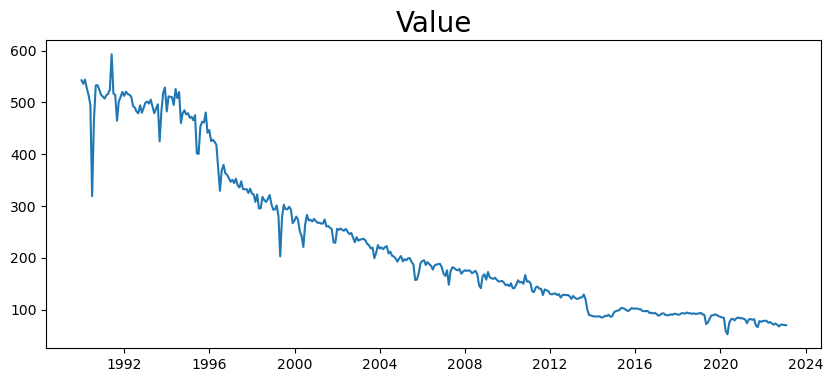

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(data["value"])
plt.title("Value", fontsize=20)
plt.show()

$\color{red}{\text{Answer 1:}}$ The chosen series represents the industrial production index corrected from seasonal variations and working days, on a monthly frequency. The IPI make it possible to follow the monthly evolution of industrial activity in France and in construction.

### Question 2

#### Stationarisation

In [40]:
def diff(series, order = 1, s=1):
    diffs = series[s:] - series[:-s]
    diffs = np.concatenate([diffs, [0]*s])
    
    if order == 1:
        return diffs
    else:
        return diff(diffs, order - 1, s)

def box_cox(series, alpha=0):
    if alpha == 0:
        return np.log(series)
    elif alpha > 0:
        return (np.power(series, alpha)-1)/alpha
    else:
        raise Exception("alpha must be a positive real.")

In [41]:
for d in range(1, 11):
    data[f"diff_{d}"] = diff(data["value"].values, order=d)

In [42]:
data["log_value"] = box_cox(data["value"])

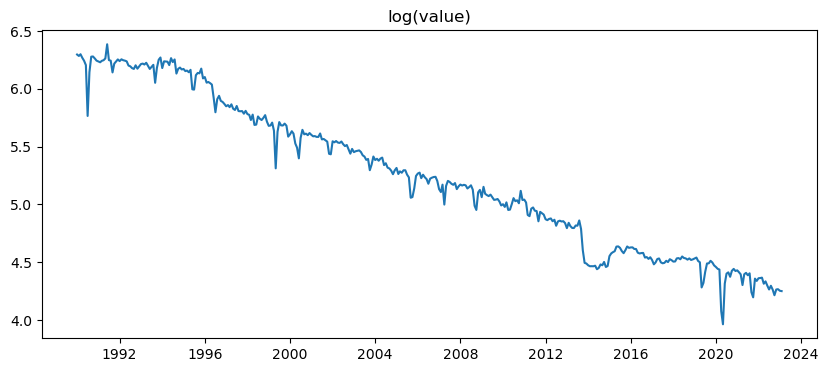

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(data["log_value"])
plt.title("log(value)")
plt.show()

In [44]:
for d in range(1, 11):
    data[f"log_diff_{d}"] = diff(data["log_value"].values, order=d)

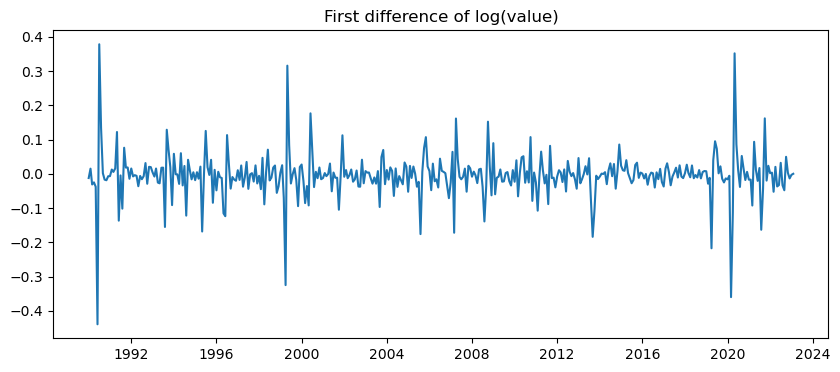

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(data["log_diff_1"])
plt.title("First difference of log(value)")
plt.show()

Evaluating stationarity of variable log_diff_1


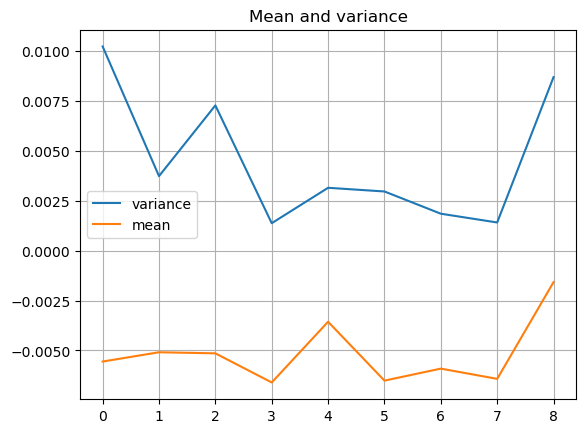

In [46]:
index_list = np.linspace(start=0, stop=data.shape[0], num=10, dtype=int)

def isStationary(variable):
    variances = []
    averages = []
    print("Evaluating stationarity of variable", variable)
    for i in range(len(index_list)-1):
        X = data[variable][index_list[i]:index_list[i+1]]
        variance = X.var()
        average = X.mean()

        variances.append(variance)
        averages.append(average)
    return averages, variances
#     print(f"Data from {index_list[i]} to {index_list[i+1]}: mean = {average}, var = {variance}")


variable = "log_diff_1"
averages, variances = isStationary(variable)
plt.plot(variances, label = "variance")
plt.plot(averages, label = "mean")
plt.legend()
plt.title("Mean and variance")
plt.grid()
plt.show()

Variance appears to be constant. We shall say that this time series is stationary.

In [47]:
result = adfuller(data["log_value"].values)
print("ADF Statistic %f" % result[0])
print("p-value : %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic -0.394037
p-value : 0.911090
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


In [48]:
result = adfuller(data["log_diff_1"].values)
print("ADF Statistic %f" % result[0])
print("p-value : %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic -9.217573
p-value : 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


The leading rule is to always use the simplest model. So we're gonna go with log_diff_1.

$\color{red}{\text{Answer 2:}}$ To make the series stationary, we transformed it using a box_cox transformation of parameter $\lambda = 0$, before using the first difference operator.

On the resulting series, the mean and variance tends to stay constante across time, and the Augmented Dickey-Fuller Test validated this hypothesis at the 1% threshold. 

### Question 3

$\color{red}{\text{Answer 3:}}$ See graphics below.

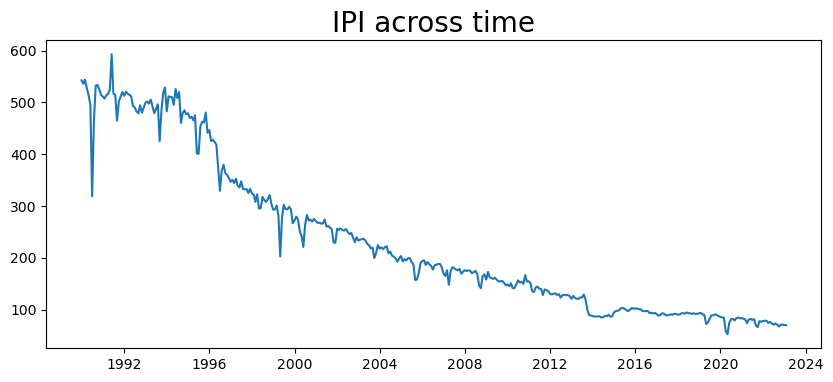

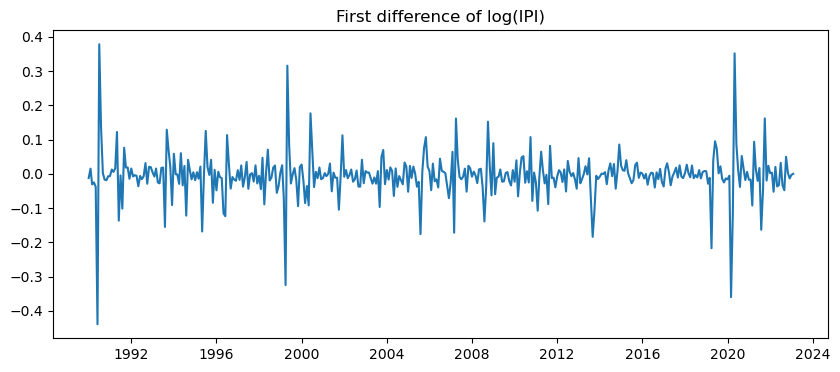

In [53]:
plt.figure(figsize=(10, 4))
plt.plot(data["value"])
plt.title("IPI across time", fontsize=20)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(data["log_diff_1"])
plt.title("First difference of log(IPI)")
plt.show()

## Part 2 : ARMA models

### Question 4 and question 5

In [99]:
X = data["log_diff_1"].values
Y = data["log_value"].values
Z = data["value"].values

At last, we want to predict Z. We know that X, the corrected time series, is stationary.

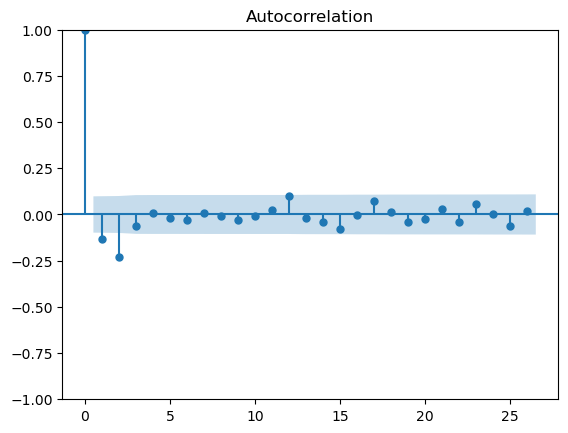

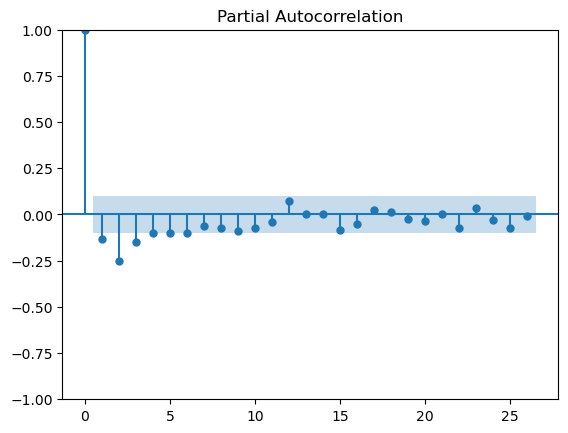

In [120]:
acf_plot = plot_acf(X)
pacf_plot = plot_pacf(X)

We see that $\color{blue}{\text{empirical autocorrelations and partial autocorrelations decrease rapidly}}$. 
Hence, an ARMA model can be fitted on the series.

Pacf is statistically different from 0 for lags 1, 2, 3. We will then try $p = 0, 1, 2, 3$.

Acf is statistically different from 0 for lags 1, 2. We will then try $q = 0, 1, 2$.

In [150]:
model = ARIMA(Y, order=(3, 0, 2)) # Function ARMA not implemented in statsmodel. But ARMA(p, q) = ARIMA(p, 0, q)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  398
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 532.644
Date:                Tue, 18 Apr 2023   AIC                          -1051.288
Time:                        11:53:48   BIC                          -1023.383
Sample:                             0   HQIC                         -1040.235
                                - 398                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2530      0.910      5.776      0.000       3.470       7.036
ar.L1          1.3112      0.487      2.692      0.007       0.356       2.266
ar.L2         -0.3879      0.802     -0.484      0.629      -1.960       1.184
ar.L3          0.0763      0.331      0.231      0.818      -0.572       0.724
ma.L1         -0.5273      0.487     -1.083      0.279      -1.482       0.427
ma.L2         -0.1199      0.436     -0.275      0.783      -0.975       0.735
sigma2         0.0040      0.000     37.143      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              2880.47
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -1.76
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

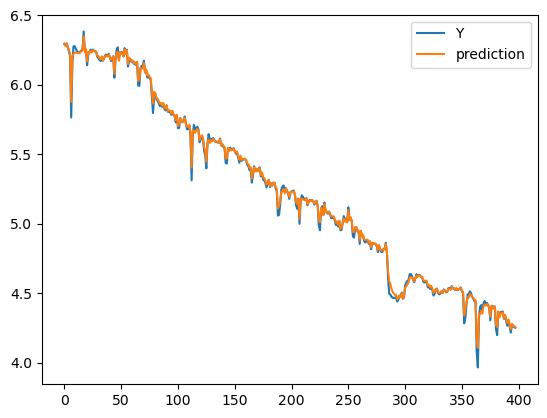

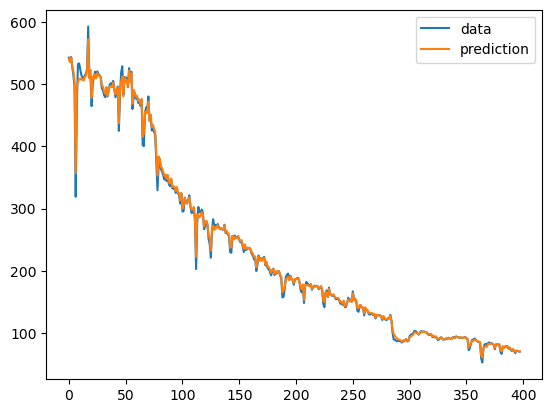

In [151]:
predictions = model_fit.predict(1, 398)
plt.plot(Y, label="Y")
plt.plot(predictions, label="prediction")
plt.legend()
plt.show()

plt.plot(Z, label="data")
plt.plot(np.exp(predictions), label="prediction")
plt.legend()
plt.show()

In [152]:
residuals = Y - predictions
print("Mean Absolute Percent Error: ", round(np.mean(abs(residuals)), 4))
print("Root mean squared Error: ", round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Percent Error:  0.0139
Root mean squared Error:  0.0218


## Part III : Prediction 